# Kernel PCA

## Task 1
In this task, we will once again work with the MNIST training set as provided on Moodle. Choose three digit classes, e.g. 1, 2 and 3 and load `N=1000` images from each of the classes to the workspace. Store the data in a normalized matrix `X` of type size `(784,3*N)`. Furthermore, generate a color label matrix `C` of dimensions `(3,3*N)`. Each row of `C` assigns an RGB color vector to the respective column of X as an indicator of the digit class. Choose `[0, 0, 1]`, `[0, 1, 0]` and `[1, 0, 0]` for the three digit classes.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import misc
import glob

# load mnist
n_class_samples = 500 # number of imported samples per class
data_path_main = './mnist/'

# imported numbers
imp_numbers = [1, 2, 3]

num_folders = ['d' + str(n) for n in imp_numbers]
print('Loading MNIST numbers {}'.format(', '.join(str(i) for i in imp_numbers)))

image_list = [] # initialize list of images
for num in num_folders:
    filelist = glob.glob(data_path_main + num + '/*.png')[:n_class_samples]
    for filename in filelist:
        im = misc.imread(filename)
        image_list.append(np.double(im).ravel()/255) # append vectoried and normalized image

X_mnist = np.array(image_list).T/255.0 # convert list to numpy array

# generate labels
y_mnist = np.zeros((3,3*n_class_samples))
y_mnist[0,:n_class_samples] = np.ones((n_class_samples))
y_mnist[1,n_class_samples:2*n_class_samples] = np.ones((n_class_samples))
y_mnist[2,2*n_class_samples:] = np.ones((n_class_samples))

print('{} images loaded and vectorized'.format(X_mnist.shape[1]))

Loading MNIST numbers 1, 2, 3


/home/salamander/Apps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


1500 images loaded and vectorized


a) Compute the principal subspace `U` of dimension 2 of `X_mnist`. Create a `C`-colored scatter plot of the scores of `X_mnist` with respect to this subspace.

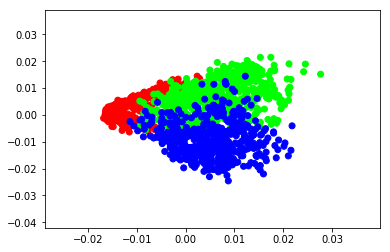

In [26]:
#%% peform PCA
k = 2 # number of PCs

# center data
x_mean = np.mean(X_mnist, axis=1)
X_cent = X_mnist - np.expand_dims(x_mean, axis=1)

# compute SVD
_, s, Vt = np.linalg.svd(X_cent)

# compute reduced variables
S = np.dot(np.diag(s[:k]), Vt[:k, :])

# plot as scatter plot
plt.scatter(S[0,:], S[1,:], c=y_mnist.T)
plt.show()

b) Write a Python function `kgram` which expects a data matrix `X` of size `(p,N_X)` and a kernel function handle kappa as its input. It returns the Gram matrix `K` of `X` with respect to `kappa`. In order to reduce the number of for loops, assume that `kappa` accepts matrices as its input and calculates the kernel column-wise, returning a row vector as its output.

In [27]:
#%% generate gram matrix
def kgram(X, kappa):
    p, N_X = X.shape
    K = np.zeros((N_X, N_X)) #initialize K
    # iterate over rows
    for ip in range(N_X):
        # only fill upper triangular matrix
        YY = np.tile(np.expand_dims(X[:,ip],1), (1, N_X - ip))
        K[ip, ip:] = kappa(X[:,ip:], YY)
        
    # return full symmetric matrix K
    return K + np.tril(K.T, k=-1)

c) Write a Python function `kpca` which expects a  data matrix `X`, a kernel function handle `kappa` and the dimension of the intrinsic subspace `k` as its input, and returns the Kernel PCA scores `S` of `X`. The representation is to be computed according to the equation (7.11) in the lecture notes.

In [28]:
# define KPCA using truncated SVD
from sklearn.decomposition import TruncatedSVD
def kpca(X, kappa, k):
    p, N_X = X.shape
    # compute uncentered gram matrix
    K = kgram(X, kappa)
    # centering matrix
    H = np.eye(N_X) - np.ones((N_X, N_X))/N_X
    # center gram matrix
    K_centered = H.dot(K).dot(H)
    # compute truncated SVD
    _, s, Vt = np.linalg.svd(K_centered)
    # take sqrt of eigenvalues
    s = np.sqrt(s[:k])
    # compute scores
    S = np.dot(np.diag(s), Vt[:k])
    
    return S

d) Generate scatter plots of the scores produced by `kpca(X_mnist,kappa,k)`. Choose `k=3` and try different kernel functions. What are the names of the kernels? Try out different values for `c`, `d` and `sigma`. Refer to the lecture notes for the value ranges.

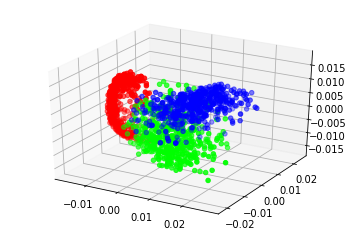

In [29]:
def kappa1(X, Y):
    k_row = np.sum(X*Y, axis=0)
    return k_row

S1 = kpca(X_mnist, kappa1, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S1[0,:], S1[1,:], S1[2,:], c=y_mnist.T)

plt.show()

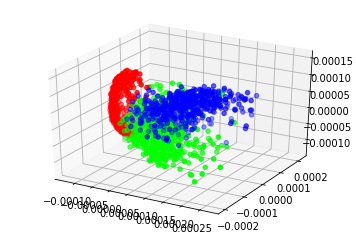

In [30]:
#%% Polynomial kernel
def kappa2(X, Y):
    c = 0.004 # hyperparameters
    d = 3
    k_row = (np.sum(X*Y, axis=0) + c)**d
    return k_row

S2 = kpca(X_mnist, kappa2, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S2[0,:], S2[1,:], S2[2,:], c=y_mnist.T)

plt.show()

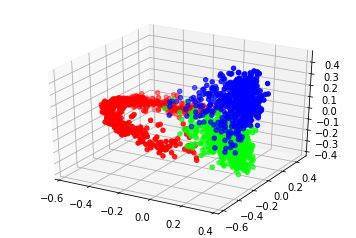

In [31]:
def kappa3(X, Y):
    sigma = 0.02
    k_row = np.exp(- np.sum((X-Y)**2, axis = 0) / (2*sigma**2))
    return k_row

S3 = kpca(X_mnist, kappa3, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S3[0,:], S3[1,:], S3[2,:], c=y_mnist.T)

plt.show()